In [5]:
import networkx as nx
import numpy as np
import pandas as pd
import sys
from time import time
import os

# LOCAL LIBRARIES
sys.path.append('../src')
import chambers_and_audiences as ca
import communities as cm
import similarity_metrics as sm
import polarization as pol
import echo_chambers as ec
import matplotlib
import json

In [6]:
import matplotlib.pyplot as plt 
%matplotlib inline

# Reading data 

We take a retweet network from the amazing [Netzschleuder](https://networks.skewed.de/) cataloge. The retweet network consists of the conversation related to the announcement of the discovery of a new fundamental particle with the features of the Higgs boson on 4th July 2012. Data covers 1-7 July 2012 so we only have one week. The data was used in [this paper](https://doi.org/10.1038/srep02980).

In [7]:
dir = '../data/climateData/'
edgelists = []
for file in os.scandir(dir):
    edgelists.append(pd.read_csv(dir + file.name))

# Applying our methodology

## High-impact and leading users

In [8]:
%%time
## GET PERSISTENT USERS ## 

N = 50 # number of popular users per week
M = 50 # number of persistent users

# impact, leading users I^Δ(t), users' frequencies
w_IΔ, IΔ, users_persistence = ca.temporal_leading_impacts(edgelists, N, M)
_, I_highimpact = ca.temporal_highimpact_impacts(edgelists, N)

users_highimpact_persistence = ca.get_users_persistence( I_highimpact )
leading_users = ca.get_users_from_users_persistence_dict(users_persistence)

leading_voices_dynamics = pd.DataFrame( columns=leading_users )

for (t, w_t) in enumerate( w_IΔ ):    
    leading_voices_dynamics.loc[ t ] = w_t['weight']

/Users/matthewbone/Documents/Coding/VSCode/msc-sds-data/twitterChambers/example/../src/chambers_and_audiences.py:58: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  return edgelist.groupby( target ).sum().sort_values( weight )
/Users/matthewbone/Documents/Coding/VSCode/msc-sds-data/twitterChambers/example/../src/chambers_and_audiences.py:58: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  return edgelist.groupby( target ).sum().sort_values( weight )
/Users/matthewbone/Documents/Coding/VSCode/msc-sds-data/twitterChambers/example/../src/chambers_and_audiences.py:58: FutureWarning: The default value of numeric_only 

CPU times: user 196 ms, sys: 15.2 ms, total: 211 ms
Wall time: 211 ms


## Chambers and audiences

In [9]:
%%time 
### CHAMBERS AND AUDIENCES ### 

chambers_dynamic = ca.temporal_chambers( IΔ, edgelists, users_excluded=I_highimpact, return_networks=False )
audiences_dynamic = ca.temporal_audiences( IΔ, edgelists, return_networks=False )

## AGGREGATE CHAMBERS: Chambers of each user aggregated over all weeks
chambers_aggregate = dict()
for user in leading_users:
    
    chambers_aggregate[user] = set()
    for (t, chamber_t) in enumerate(chambers_dynamic):
        try:
            chambers_aggregate[user] = chambers_aggregate[user].union( chamber_t[user] )
        except:
            pass

## AGGREGATE AUDIENCES: Audiences of each user aggregated over all weeks
audiences_aggregate = dict()
for user in leading_users:
    audiences_aggregate[user] = set()
    for (t, el) in enumerate(edgelists):
        try:
            audience_t = ca.get_audience(user, el)
            audiences_aggregate[user] = audiences_aggregate[user].union( audience_t )
        except:
            pass

CPU times: user 5.58 s, sys: 63.7 ms, total: 5.64 s
Wall time: 5.65 s


In [28]:
len(audiences_dynamic[3])

11

## Chamber overlaps

In [10]:
%%time
### CHAMBER OVERLAPS ###   

## Weekly overlap matrices
Q_dynamic = sm.temporal_similarity_matrices(chambers_dynamic)
Q_edgelists_dynamic = [ sm.edgelist_from_adjacency ( Q ) for Q in Q_dynamic ]

## Aggregate overlap matrics
Q_static = sm.aggregate_similarity_matrices( Q_dynamic )

CPU times: user 82.6 ms, sys: 2.13 ms, total: 84.7 ms
Wall time: 83.9 ms


## Unsupervised spectral clustering

In [11]:
%%time
### COMMUNITIES/IDEOLOGIES (UNSUPERVISED) ### 
P_spectral, (l,u) = cm.communities_spectral( Q_static.replace(np.nan,0), mode=2, cutoff=0, return_spectra=True)

CPU times: user 1.82 ms, sys: 1.37 ms, total: 3.18 ms
Wall time: 3 ms


## Polarization

In [12]:
%%time
### POLARIZATION DYNAMICS ### 
polarization_dynamic_spectral = [ pol.network_polarization( E, P_spectral, polarisation_func=pol.polarisation6  ) for E in Q_edgelists_dynamic ]
polarization_dynamic_spectral

CPU times: user 14 ms, sys: 1.08 ms, total: 15.1 ms
Wall time: 14.5 ms


/Users/matthewbone/Documents/Coding/VSCode/msc-sds-data/twitterChambers/example/../src/polarization.py:42: RuntimeWarning: invalid value encountered in double_scalars
  return (in_strength - out_strength)/(in_strength + out_strength)


[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

## Echo chambers

In [13]:
%%time
## AUDIENCES OF HISH IMPACT USERS
high_impact_audiences = []
for t, high_impacts_t in enumerate( I_highimpact ):
    high_impact_audiences.append( ca.get_audiences_of_users( high_impacts_t, edgelists[t] ) )
    
## NUMBER OF USERS PER EDGELIST
num_users_weekly = np.array( [ len( set( el.source.unique() ).union( set( el.target.unique() ) ) ) for el in edgelists ] )
num_users_weekly = pd.Series( num_users_weekly )

## OBTAIN ECHO CHAMBERS 
echo_chambers = ec.echo_chambers_dynamics( audiences_dynamic, chambers_dynamic, P_spectral ) 

CPU times: user 2.51 s, sys: 36.3 ms, total: 2.55 s
Wall time: 2.55 s


## Augmented echo chambers

In [14]:
%%time 
## COMPUTE HIGH-IMPACT SCORES
high_impact_scores = ec.ideology_scores_dynamics( high_impact_audiences, echo_chambers, users_excluded=leading_users, score_func=ec.score_1 )

## OBTAIN AUGMENTED ECHO CHAMBERS
thresh = 0.2 # η in the paper
augmented_echo_chambers = ec.augment_echo_chambers( high_impact_scores, high_impact_audiences, echo_chambers, thresh=thresh, users_excluded=leading_users )

CPU times: user 172 ms, sys: 10.5 ms, total: 183 ms
Wall time: 182 ms


# Example plots

## Chamber overlap distribution

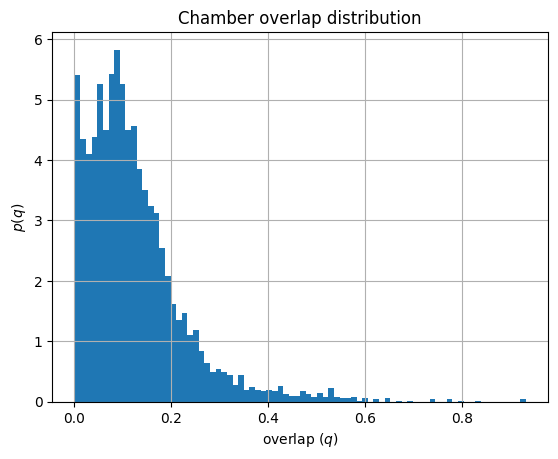

In [15]:
q_agg = sm.flatten_similarity_matrices( Q_dynamic )
bins = np.histogram( q_agg, bins=80 )[1] #get the bin edges

## chamber overlap distribution
fig, ax1 = plt.subplots()
ax1.hist(q_agg, bins, density=True)
ax1.grid('on')

plt.xlabel('overlap $(q)$')
plt.ylabel('$p(q)$')
plt.title('Chamber overlap distribution');

## Chamber overlap matrix and network

In [16]:
print(matplotlib.get_cachedir())

/Users/matthewbone/.matplotlib


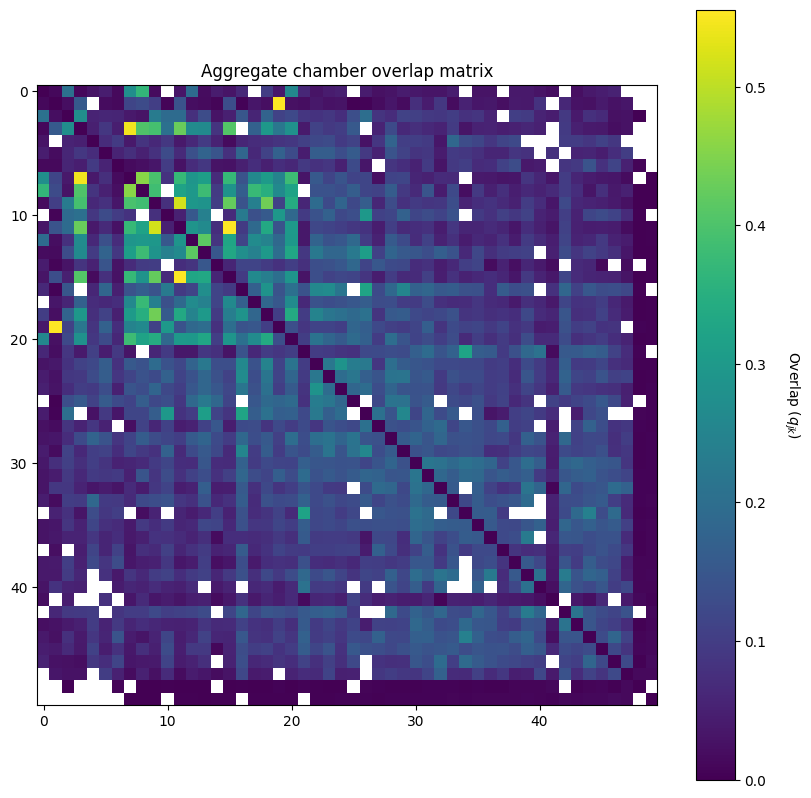

In [17]:
Q_spectral = sm.reorder_similarity_matrix(Q_static, P_spectral)

plt.figure( figsize=(10,10) )
plt.imshow(Q_spectral)
cbar = plt.colorbar()
cbar.set_label('Overlap ($q_{jk}$)', rotation=270, labelpad=25)
plt.title('Aggregate chamber overlap matrix');

## Ideology score distribution

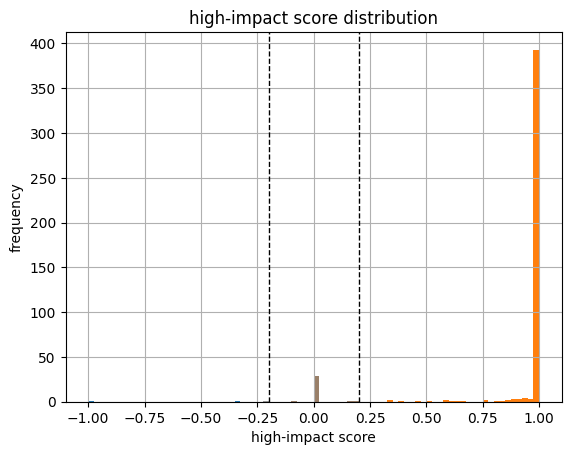

In [18]:
score_values = ec.flatten_array_of_dicts( high_impact_scores )
score_values = -np.sort( score_values )

s_anti = score_values[ score_values < -thresh ]
s_pro = score_values[ score_values > -thresh ]
s_neutral = score_values[ (score_values >= -thresh) & (score_values <= thresh) ]

bins = np.histogram( score_values, bins=80 )[1] #get the bin edges
bw = np.diff(bins)[0]

# qC, fKDE = sm.get_pdf_cutoff( score_values, return_kde_dist=True, bw_method=bw )

plt.hist( s_anti, bins, density=False  );
plt.hist( s_pro, bins, density=False );
plt.hist( s_neutral, bins, density=False, alpha=0.8, color='gray' );

plt.axvline(-thresh, lw=1, ls='--', label='', color='black')
plt.axvline(thresh, lw=1, ls='--', label='', color='black')

plt.xlabel('high-impact score')
plt.ylabel('frequency')
plt.title('high-impact score distribution')
plt.grid()

## (Augmented) Echo chambers

We'll let you figure out how to plot the figures related with the echo chambers and the augmented echo chambers